# Chap07.1 - 텐서플로 추상화와 간소화, Estimator

> 추상화가 무엇이며 왜 유용한지 알아보고 텐서플로(TensorFlow)의 몇몇 대중적인 추상화 라이브러리를 간단하게 살펴보도록 하자.

## 7.1 개요

**추상화(abstraction)**이란 코드를 특정한 목적으로 일반화하여 기존 코드 **'위에 올라가는'** 코드의 계층을 의미한다. 관련있는 High-Level 기능을 묶는 방식의 재구성을 통해 코드를 감싸서 추상화한다. 따라서 쉽게 코딩할 수 있고, 가독성이 좋으며, 코드가 간소화된다.

### 7.1.1 추상화 라이브러리 둘러보기

텐서플로(TensorFlow)에서 사용할 수 있는 인기있는 추상화 라이브러리는 다음과 같다고 한다.

- `tf.estimator`
- TFLearn
- TF-Slim
- Keras

TFLearn은 별도의 설치가 필요하며 `tf.estimator`과 TF-Slim([`tf.contrib.slim`](https://github.com/tensorflow/tensorflow/tree/r1.8/tensorflow/contrib/slim))은 텐서플로에 포함되어 있다. Keras(케라스)는 2017년 구글의 공식 후원을 받아 1.1버전 부터 `tf.contrib.keras`안에 들어왔으며, 현재 이글을 작성하는 시점인 2018.06.27의 1.8버전에는 `tf.keras`로 변경됭 텐서플로의 한 부분으로 자리를 잡았다. `contrib`안의 라이브러리들은 **기부된(contributed)** 것을 의미하며 정식으로 반영되기 전까지 테스트가 더 필요하다는 것을 의미한다. 

`tf.estimator`은 Python의 대표적인 머신러닝 모듈인 [Scikit-Learn](http://scikit-learn.org/stable/index.html)(`sklearn`)의 스타일처럼 복잡한 딥러닝 모델을 쉽게 작성할 수 있도록 해주는 라이브러리다. Keras와 마찬가지로 [`tf.contrib.learn`](https://github.com/tensorflow/tensorflow/tree/r1.8/tensorflow/contrib/learn)으로 텐서플로에 들어왔으며, 현재 1.8버전(2018.06.27)에는 `tf.estimator`로 옮겨졌으며 `tf.contrib.learn`은 유지되고 있지만 사용할 경우 `deprecated` 경고가 나타난다.

TF-Slim은 주로 복잡한 합성곱 신경망(Convolutional Networks)을 쉽게 설계할 수 있도록 만들어졌으며 다양한 Pre-Trained 모델을 제공해 학습 시간을 단축시킬 수 있다. 

## 7.2 tf.estimator

`tf.estimator`는 `sklearn`과 유사하게 `Estimator`(모델들을 부르는 용어)로 동작하는데 이것을 이용하면, 빠르게 모델을 학습할 수 있다. 대표적인 Estimator들은 아래와 같으며, [`tf.estimator`](https://www.tensorflow.org/api_docs/python/tf/estimator)에서 다양한 Estimator들을 살펴볼 수 있다.

| Estimator                                                    | 설명                                                         |
| ------------------------------------------------------------ | ------------------------------------------------------------ |
| [`LinearRegressor()`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) | 주어진 관측치에 대해 Linear regression을 이용해 예측         |
| [`LinearClassifier()`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) | Linear Model을 이용한 다중분류(multi-classification), 클래스가 2개일 경우 binary classification |
| [`DNNRegressor()`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) | TensorFlow DNN 모델을 이용한 regression                      |
| [`DNNClassifier()`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) | TensorFlow DNN 모델을 이용한 classification                  |

`tf.contrib.learn`에서 `tf.estimator`로 옮겨올때 아래의 `Estimator`는 반영이 되지 않았다.

- `DynamicRnnEstimator`: Consider a custom `model_fn`.
- `KMeansClustering`: Use `tf.contrib.factorization.KMeansClustering`.
- `LogisticRegressor`: Not supported. Instead, use `binary_classification_head` with a custom `model_fn`, or with `DNNEstimator`.
- `StateSavingRnnEstimator`: Consider a custom `model_fn`.
- SVM: Consider a custom `model_fn`.
- `LinearComposableModel` and `DNNComposableModel`: Not supported. Consider `tf.contrib.estimator.DNNEstimator`, or write a custom model_fn.
- `MetricSpec`: Deprecated. For adding custom metrics to canned Estimators, use `tf.contrib.estimator.add_metrics`.

위의 Estimator를 사용하는 방법은 다음과 같다.

1. 클래스 **인스턴스화**(instance)
    - `model = tf.estimator.<some_Estimator>()`
2. 학습 데이터를 사용해 모델을 **학습** 
    - `model.train()`
3. 학습된 모델을 **평가**(evaluate)
    - `model.evaluate()`
4. 테스트 데이터를 이용해 결과를 **예측**(predict)
    - `model.predict()`

### 7.2.1 선형회귀 - Linear Regression

선형회귀(linear regression)은 데이터 집합 $\left\{ y_i, x_{i1}, \dots , x_{ip} \right\}_{i=1}^{n}$ 에 대해, 종속변수 $y_i$와 $p$개의 설명변수 $x_i$ 사이의 선형 관계를 모델링한다(출처: [wikipedia](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%ED%9A%8C%EA%B7%80)).

$$
y_i = w_1 x_{i1} + \cdots + w_{p} x_{ip} + \epsilon_i = \mathbf{x}_{i}^{T} \mathbf{W} + \epsilon_i, \quad i = 1, \dots , n
$$

위의 선형회귀 모델을 Scikit-Learn(사이킷런)에서 제공하는 [보스턴 하우징(Boston Housing)](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)데이터에 적용해보도록 하자. 먼저 추상화 라이브러리를 사용하지 않은 텐서플로(TensorFlow)코드를 구현한 뒤, 이것을 `tf.estimator.LiearRegressor()`를 이용해 구현해 볼 것이다.

보스턴 하우징 데이터 설명은 다음과 같다. 종속변수(타겟변수)는 소유자가 거주 중인 주택 가격의 중간값(median)이다.

|      | Feature | 설명                                                      |
| ---- | ------- | --------------------------------------------------------- |
| 1    | CRIM    | 마을의 1인당 범죄율                                       |
| 2    | ZN      | 2만 5천 평방 피트 이상으로 구획된 택지의 비율             |
| 3    | INDUS   | 마을당 비상업 업무 지구의 비율                            |
| 4    | CHAS    | 찰스강 더미 변수 (인접: 1, 아니면: 0)                     |
| 5    | NOX     | 질소산화물 농도                                           |
| 6    | RM      | 주택당 평균 방의 수                                       |
| 7    | AGE     | 1940년 이전에 지어진 건물의 비율                          |
| 8    | DIS     | 5개의 보스턴 고용 센터까지의 가중 거리                    |
| 9    | RAD     | 방사형 고속도로까지의 접근성 지수                         |
| 10   | TAX     | 1만 달러당 부가가치세                                     |
| 11   | PTRATIO | 마을별 학생 대 교사 비율                                  |
| 12   | B       | $1000(\text{Bk}-0.63)^{2}$, $\text{Bk}$: 마을의 흑인 비율 |
| 13   | LSTAT   | 하위 계층의 비율(%)                                       |

먼저 Scikit-Learn에서 보스턴 하우징 데이터를 불러온다. 설명변수로 쓰일 데이터들을 [`StandardScaler()`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)를 이용해 정규화 해준다. `StandardScaler`의 수식은 다음과 같으며 *Z-Score*라고도 한다.

$$
z = \frac{\text{Data point} - \text{mean}}{\text{standard deviation}} = \frac{x-\mu}{\sigma}
$$

In [1]:
from sklearn import datasets, metrics, preprocessing

boston = datasets.load_boston()
x_data = preprocessing.StandardScaler().fit_transform(boston.data)
y_data = boston.target

print('x_data.shape :', x_data.shape)
print('y_data.shape :', y_data.shape)

x_data.shape : (506, 13)
y_data.shape : (506,)


#### Natvie TensorFlow

먼저 추상화 라이브러리를 사용하지 않고, 순수 텐서플로를 이용해 선형회귀를 모델링 해보도록 하자. 

In [2]:
import tensorflow as tf

In [3]:
x = tf.placeholder(tf.float64, shape=(None, 13))
y_true = tf.placeholder(tf.float64, shape=(None))

with tf.name_scope('inference'):
    w = tf.Variable(tf.zeros([1, 13], dtype=tf.float64, name='weights'))
    b = tf.Variable(0, dtype=tf.float64, name='bias')
    y_pred = tf.matmul(w, tf.transpose(x)) + b
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.square(y_true-y_pred))  # MSE
    
with tf.name_scope('train'):
    learning_rate = 0.1
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for step in range(200):
        MSE, _ = sess.run([loss, train], feed_dict={x: x_data, 
                                                    y_true: y_data})
    
        if (step+1) % 40 == 0:
            print('Step: {:2d}\t MSE: {:.5f}'.format(step+1, MSE))

Step: 40	 MSE: 22.30192
Step: 80	 MSE: 22.00200
Step: 120	 MSE: 21.93284
Step: 160	 MSE: 21.91024
Step: 200	 MSE: 21.90225


#### tf.estimator

이번에는 위와 똑같은 기능을 하는 코드를 `tf.estimator.LinearRegressor()`를 이용해 구현해 보도록 하자. 아래의 코드에서 확인할 수 있듯이 간단한 코드로 Linear Regression을 구현할 수 있다.

In [4]:
NUM_STEPS = 200
MINIBATCH_SIZE = 506

feature_column = [tf.feature_column.numeric_column(key='x', shape=13)]
train_input_fn = tf.estimator.inputs.numpy_input_fn(
        {'x': x_data}, y_data, batch_size=MINIBATCH_SIZE, shuffle=False)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        {'x': x_data}, y_data, batch_size=MINIBATCH_SIZE, shuffle=False)

reg = tf.estimator.LinearRegressor(
        feature_columns=feature_column,
        optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.001), 
        model_dir='./model/boston')

reg.train(input_fn=train_input_fn, steps=NUM_STEPS)
MSE = reg.evaluate(input_fn=eval_input_fn, steps=1)

print(MSE)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0c3d9cd908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./model/model.ckpt.
INFO:tensorflow:loss = 299626.34, step = 0
INF

### 7.2.2 DNN 분류기

이번에는 [2.4 - Softmax Regression](http://excelsior-cjh.tistory.com/149?category=940399)에서 구현한 MNIST 분류기를 `tf.estimator.DNNClassifier()`를 이용해 구현해보도록 하자.

In [5]:
import sys
import numpy as np
import tensorflow as tf


# MNIST 데이터 불러오기 위한 함수 정의
def mnist_load():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

    # Train set
    train_x = train_x.astype('float32') / 255.
    train_y = train_y.astype('int32')
    # Test set
    test_x = test_x.astype('float32') / 255.
    test_y = test_y.astype('int32')
    return (train_x, train_y), (test_x, test_y)

# MNIST 데이터 불러오기
(train_x, train_y), (test_x, test_y) = mnist_load()

# Define train_input_fn
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': train_x}, y=train_y, shuffle=True, batch_size=MINIBATCH_SIZE
)

In [7]:
NUM_STEPS = 5000
MINIBATCH_SIZ = 128

feature_columns = [tf.feature_column.numeric_column('x', shape=[28, 28])]

dnn = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[200],
    n_classes=10,
    optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.2),
    model_dir='./model/DNNClassifier'
)

dnn.train(
    input_fn=train_input_fn,
    steps=NUM_STEPS)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0bca1f3908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./model/model.ckpt.
INFO:tensorflow:loss = 1178.339, step = 0
INFO

In [8]:
# Define eval_input_fn
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': test_x}, y=test_y, shuffle=False
)

test_acc = dnn.evaluate(input_fn=eval_input_fn, steps=1)['accuracy']
print('test accuracy: {}'.format(test_acc))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-27-10:03:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-119
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-06-27-10:03:23
INFO:tensorflow:Saving dict for global step 119: accuracy = 0.9453125, average_loss = 0.2138238, global_step = 119, loss = 27.369446
test accuracy: 0.9453125


### 7.2.3 tf.feature_column

텐서플로는 [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column)를 통해 다양한 데이터의 특징(Feature)들을 처리해준다. 7.2.1과 7.2.2에서 `tf.estimator`를 이용해 Estimator를 만들어줄때 [`tf.feature_column.numeric_column()`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column)를 이용해서 데이터의 특징(feature)을 정의해줬다. 

이렇듯 수치형 데이터도 있지만, 실제 세계에서는 아래의 예시(출처: [TensorFlow.org](https://www.tensorflow.org/get_started/feature_columns))와 같이 수치형 데이터 뿐만 아니라 다양한 특징(특성)들을 가지는 데이터들이 존재한다.

![](./images/feature_cloud.jpg)

`tf.feature_column`이 제공하는 특징 처리 중 몇가지 예로는 범주형(categorical) 데이터를 희소 벡터, 즉 one-hot 인코딩(또는 **더미 인코딩**, dummy encoding)해주며, 또는 수치형 데이터를 구간별로 버킷화(bucketize)한 뒤 더미 인코딩 해준다. 이 외에도 다양한 특징들을 처리해주는데 자세한 내용은 [TensorFlow.org](https://www.tensorflow.org/get_started/feature_columns)에서 확인할 수 있다.

`tf.feature_column`은 크게 `CategoricalColumn`과 `DenseColumn`으로 이루어져 있으며 이 둘을 동시에 상속받는 `bucketized_column`이 있다.(출처: [TensorFlow.org](https://www.tensorflow.org/get_started/feature_columns))

![](./images/some_constructors.jpg)

그렇다면, 이러한 `tf.feature_column`을 어떻게 사용하는지 간단한 샘플 데이터로 사용법을 알아보도록 하자.

예를 들어, 무게(weight)와 종족(species) 두 개의 특징(feature)으로 타겟변수인 키(height)를 `tf.estimator.LinearRegressor()`를 이용해 예측한다고 가정해보자. 각 무게를 100으로 나누고 종(species)에 따른 상수(`Human=1, Goblin=0.98, ManBear=1.1`) 을 추가해 샘플 데이터를 아래의 코드와 같이 만들어준다.

In [1]:
# Generate example categorical data
import numpy as np
import pandas as pd

N = 10000
weight = np.random.randn(N)*5 + 70
spec_id = np.random.randint(0, 3, N)
bias = [0.9, 1, 1.1]
height = np.array([weight[i]/100 + bias[b] for i, b in enumerate(spec_id)])
spec_name = ['Goblin', 'Human', 'ManBears']
spec = [spec_name[s] for s in spec_id]

생성한 예제 샘플 데이터를 `matplotlib`을 이용해 시각화 해보자.

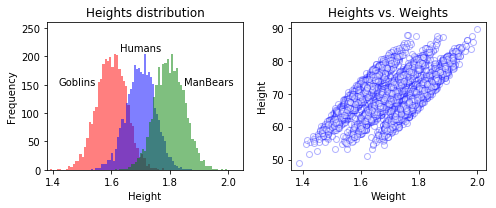

In [2]:
# plot and create data frame
%matplotlib inline
import matplotlib.pyplot as plt

colors = ['r','b','g']
f,axarr = plt.subplots(1,2,figsize = [7,3])
ax = axarr[0]
for ii in range(3):
    ax.hist(height[spec_id == ii],50,color=colors[ii],alpha=0.5)
    ax.set_xlabel('Height')
    ax.set_ylabel('Frequency')
    ax.set_title('Heights distribution')

height = height + np.random.randn(N)*0.015
ax.text(1.42,150,'Goblins')
ax.text(1.63,210,'Humans')
ax.text(1.85,150,'ManBears')

ax.set_ylim([0,260])
ax.set_xlim([1.38,2.05])

df = pd.DataFrame({'Species':spec,'Weight':weight,'Height':height})

ax = axarr[1]
ax.plot(df['Height'],df['Weight'],'o',alpha=0.3,mfc='w',mec='b')
ax.set_xlabel('Weight')
ax.set_ylabel('Height')
ax.set_title('Heights vs. Weights')
    
plt.tight_layout()
plt.show()

이제, `LinearRegressor()`의 입력(Input)으로 넣어주기 위해 `tf.feature_column`을 이용해 각 변수의 특성을 지정해준다. `Weight`는 몸무게이므로 연속형 변수임을 지정하는 `numeric_column()`을 사용한다. `Species`는 범주형(categorical) 변수이고, 값이 단어(vocabulary)로 구성되어 있으므로 `categorical_column_with_vocabulary_list()`를 사용해 특성을 지정해준다. 따라서, 변주형 변수인 `Species`는 아래의 그림처럼 데이터가 one-hot 벡터로 매핑된다.

<img src="./images/cat-vocab.png" height="70%" width="70%"/>

이렇게 처리된 FeatureColumn들을 `LinearRegressor()`의 `feature_columns=`인자에 리스트 형태로 넣어준다.  

In [3]:
import tensorflow as tf

# Feature Columns
Weight = tf.feature_column.numeric_column(key='Weight')
Species = tf.feature_column.categorical_column_with_vocabulary_list(
            key='Species',
            vocabulary_list=['Goblin', 'Human', 'ManBears'])

# LinearRegressor() Estimator
reg = tf.estimator.LinearRegressor(feature_columns=[Weight, Species], 
                                   model_dir='./model/sample')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000293A1B74470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


위에서 정의한 `LinearRegressor()`를 학습시킬때(`reg.train()`) `input_fn`인자에 학습에 사용할 데이터를 반환하는 캡슐화된 입력함수를 별도로 만들어줘야 한다. 아래의 코드에서 `input_fn`이 입력함수에 해당하며, `pandas`의 `DataFrame`을 입력으로 받아 텐서플로에서 사용가능한 텐서가 들어있는 `feature_cols` 딕셔너리와 `labels`을 반환한다.

`feature_cols` 딕셔너리에서 `Species`의 값은 위에서 `tf.feature_column`을 이용해 **더미 인코딩**을 해주었으므로 이러한 형태를 담을 수 있는 [`tf.SparseTensor`](https://www.tensorflow.org/api_docs/python/tf/SparseTensor)를 사용한다. `tf.SparseTensor()`는 아래의 예제와 같이 텐서(tensor)의 인덱스에 해당하는 값을 매핑해준다.

```python
tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4])
# 결과
[[1, 0, 0, 0]
 [0, 0, 2, 0]
 [0, 0, 0, 0]]
```

In [19]:
def input_fn(df):
    feature_cols = {
        'Weight': tf.constant(df['Weight'].values),
        'Species': tf.SparseTensor(
            indices=[[i, 0] for i in range(df['Species'].size)],
            values=df['Species'].values,
            dense_shape=[df['Species'].size, 1]
        )
    }
    labels = tf.constant(df['Height'].values)
    
    return feature_cols, labels

# Training
reg.train(input_fn=lambda: input_fn(df), steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model\model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2501 into ./model\model.ckpt.
INFO:tensorflow:loss = 23.630287, step = 2501
INFO:tensorflow:global_step/sec: 243.865
INFO:tensorflow:loss = 22.982862, step = 2601 (0.411 sec)
INFO:tensorflow:global_step/sec: 300.402
INFO:tensorflow:loss = 22.355034, step = 2701 (0.333 sec)
INFO:tensorflow:global_step/sec: 288.25
INFO:tensorflow:loss = 21.746227, step = 2801 (0.347 sec)
INFO:tensorflow:global_step/sec: 322.762
INFO:tensorflow:loss = 21.15587, step = 2901 (0.310 sec)
INFO:tensorflow:Saving checkpoints for 3000 into ./model\model.ckpt.
INFO:tensorflow:Loss for final step: 20.58902.


학습이 끝난 후 추정된 가중치들을 `.get_variable_value()`메소드를 이용해 변수의 값을 확인할 수 있다. 변수의 값은 `.get_variable_names()`를 통해 구할 수 있다.

In [33]:
print('variable names:\n', reg.get_variable_names())
print('='*50)

w_w = reg.get_variable_value('linear/linear_model/Weight/weights')
s_w = reg.get_variable_value('linear/linear_model/Species/weights')
b = reg.get_variable_value('linear/linear_model/bias_weights')
print('Estimation for Weight: {}'.format(w_w))
print('Estimation for Species:\n{}'.format(s_w + b))

variable names:
 ['global_step', 'linear/linear_model/Species/weights', 'linear/linear_model/Species/weights/part_0/Ftrl', 'linear/linear_model/Species/weights/part_0/Ftrl_1', 'linear/linear_model/Weight/weights', 'linear/linear_model/Weight/weights/part_0/Ftrl', 'linear/linear_model/Weight/weights/part_0/Ftrl_1', 'linear/linear_model/bias_weights', 'linear/linear_model/bias_weights/part_0/Ftrl', 'linear/linear_model/bias_weights/part_0/Ftrl_1']
Estimation for Weight: [[0.01007662]]
Estimation for Species:
[[0.8940179]
 [0.9947232]
 [1.0953919]]


### 7.2.4 tf.estimator로 사용자 정의 CNN 만들어보기

이번에는 `tf.estimator`를 사용해 자신만의 Estimator를 만들어 보자. 아래의 예제 코드는 [4장-합성곱 신경망 CNN](http://excelsior-cjh.tistory.com/152?category=940399)에서와 마찬가지로 MNIST 데이터 분류를 `tf.estimator`를 이용해 구현해 보도록한다.
먼저 네트워크를 구현하는 모델 함수(`cnn_model_fn`)와 학습 설정(`model_params`)을 포함한 객체를 만들어줘야 한다. 아래의 코드는 [TensorFlow.org](https://www.tensorflow.org/tutorials/layers)의 Tutorials를 참고하여 구현하였다.

In [87]:
# model_params
model_params = {"learning_rate": 1e-4, "dropout": 0.5}

# Generate model_fn
def cnn_model_fn(features, labels, mode, params):
    # Input Layer
    x_image = tf.reshape(features['x'], [-1, 28, 28, 1])  # (N, H, W, C)
    
    # Conv layer 1
    conv1 = tf.layers.conv2d(x_image, 32, [5,5],
                             padding='same',
                             activation=tf.nn.relu,
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
                             bias_initializer=tf.constant_initializer(0.1))
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2,2], strides=2)
    
    # Conv layer 2
    conv2 = tf.layers.conv2d(pool1, 64, [5,5],
                             activation=tf.nn.relu,
                             padding='same',
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
                             bias_initializer=tf.constant_initializer(0.1))
    pool2 = tf.layers.max_pooling2d(conv2, pool_size=[2,2], strides=2)
    
    # Fully-Connected layer
    pool2_flat = tf.reshape(pool2, [-1, 7*7*64])
    dense = tf.layers.dense(pool2_flat, 1024,
                          activation=tf.nn.relu,
                          kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          bias_initializer=tf.constant_initializer(0.1))
    dropout = tf.layers.dropout(dense, 
                                rate=params['dropout'],  # rate: dropout 시킬 비율
                                training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits layer
    logits = tf.layers.dense(dropout, 10, activation=None)
    
     # prediction
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1)
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels)
    
    # Configure the Training Op (for TRIAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
        train_op = optimizer.minimize(loss=loss,
                                      global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, 
                                        predictions=predictions['classes'])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, 
                                      eval_metric_ops=eval_metric_ops)

아래의 코드는 MNIST 데이터를 불러오기 위한 `mnist_load()`함수를 정의해주고 MNIST 데이터를 불러오는 코드이다.

In [88]:
# MNIST 데이터 불러오기 위한 함수 정의
def mnist_load():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

    # Train set
    train_x = train_x.astype('float32') / 255.
    train_y = train_y.astype('int32')
    # Test set
    test_x = test_x.astype('float32') / 255.
    test_y = test_y.astype('int32')
    return (train_x, train_y), (test_x, test_y)

# MNIST 데이터 불러오기
(train_x, train_y), (test_x, test_y) = mnist_load()

모델 함수(`model_fn`)와 학습 설정(`model_params`)를 만들었으니, 이제 `tf.estimator`를 이용해 Estimator를 인스턴스화 해준다.

In [90]:
# Generate Estimator
CNN = tf.estimator.Estimator(model_fn=cnn_model_fn,
                             params=model_params,
                             model_dir='./model/mnist_cnn')

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': train_x},
        y=train_y,
        batch_size=100,
        num_epochs=None,
        shuffle=True)

CNN.train(input_fn=train_input_fn, 
          steps=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model/mnist_cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000293A61A8B00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_cnn\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving 

학습이 끝났으면, 테스트 데이터를 이용해 모델을 평가해보자. 아래의 코드는 학습된 Estimator를 `.evaluate()`를 이용해 Estimator를 평가하는 코드이다.

In [92]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': test_x},
        y=test_y,
        num_epochs=1,
        shuffle=False)
eval_results = CNN.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-29-02:35:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/mnist_cnn\model.ckpt-1100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-29-02:35:33
INFO:tensorflow:Saving dict for global step 1100: accuracy = 0.9739, global_step = 1100, loss = 0.0923978
{'accuracy': 0.9739, 'loss': 0.0923978, 'global_step': 1100}


### 7.2.5 정리

지금까지 `tf.estimator`를 이용해 모델을 구현해 보았다. 확실히 Low-Level 텐서플로를 이용해 모델을 학습시키는 부분의 코드 수가 많이 줄어든 것을 확인할 수 있다. 

`tf.estimator`에 대한 더 많은 튜토리얼은 https://www.tensorflow.org/tutorials/ 에서 살펴볼 수 있다.